In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import datetime

db_dir = os.getcwd()
df = pd.read_csv(db_dir + r'/data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data cleanup 

In [2]:
#Explore the dataset to see what NA actually means per column 

#Qualitative data 
#Alley N/A can be recoded to none instead of N/A to show no access to alley  
#MasVnrType can be recoded to none instead of N/A to show no vanier type  
#All basement data can be recoded to none instead of N/A to show no basement 
#fireplace data can be recoded to none instead of N/A to show no fireplace 
#All garage data can be recoded to none instead of N/A to show no garage  
#Fence data can be recoded to none instead of N/A to show no fence  
#MiscFeature data can be recoded to none instead of N/A to show no missing feature   

#for electrical there is only one value that is missing so we add the most common value to that column 

#Quantitative data 
#perform mice on quantitative data 

In [3]:
# Fill in Missing values with either null or 0 depending on the data type
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna('None', inplace=True)
    else:
        df[col].fillna(0, inplace=True)

In [4]:
# Perform MICE on quantitative data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

numerical_cols = df.select_dtypes(include=[np.number]).columns
imputer = IterativeImputer(max_iter=10, random_state=0)
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [5]:
#Proceed only if there are no missing values
df.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

# Data Cleaning

In [6]:
#perform logic checks on the data 

# Get today's date for year checks
today_year = datetime.datetime.today().year

# Initialize a set to keep track of unique indices of rows with errors
error_indices = set()

# Inline logical checks without adding new columns

# LotFrontage check
lot_frontage_errors = df[df['LotFrontage'] <= 0]
if not lot_frontage_errors.empty:
    print("Errors in LotFrontage (should be positive):")
    print(lot_frontage_errors[['LotFrontage']])
    print("Explanation: LotFrontage must be a positive number. The above rows have invalid LotFrontage values.\n")
    error_indices.update(lot_frontage_errors.index)

# LotArea check
lot_area_errors = df[df['LotArea'] <= 0]
if not lot_area_errors.empty:
    print("Errors in LotArea (should be positive):")
    print(lot_area_errors[['LotArea']])
    print("Explanation: LotArea must be a positive number. The above rows have invalid LotArea values.\n")
    error_indices.update(lot_area_errors.index)

# Street check
valid_Street = {'Grvl', 'Pave'}
street_errors = df[~df['Street'].isin(valid_Street)]
if not street_errors.empty:
    print("Errors in Street (must be either 'Grvl' or 'Pave'):")
    print(street_errors[['Street']])
    print("Explanation: Street must be either 'Grvl' (Gravel) or 'Pave' (Paved). The above rows have invalid Street values.\n")
    error_indices.update(street_errors.index)

# YearRemodAdd check
year_remod_add_errors = df[
    (df['YearRemodAdd'] < df['YearBuilt']) | 
    (df['YearRemodAdd'] > today_year)
]
if not year_remod_add_errors.empty:
    print("Errors in YearRemodAdd (must be between YearBuilt and the current year):")
    print(year_remod_add_errors[['YearBuilt', 'YearRemodAdd']])
    print(f"Explanation: YearRemodAdd must be between YearBuilt and {today_year}. The above rows have invalid YearRemodAdd values.\n")
    error_indices.update(year_remod_add_errors.index)

# GarageYrBlt check
garage_yr_blt_errors = df[
    (df['GarageYrBlt'] < df['YearBuilt']) | 
    (df['GarageYrBlt'] > today_year)
]
if not garage_yr_blt_errors.empty:
    print("Errors in GarageYrBlt (must be between YearBuilt and the current year):")
    print(garage_yr_blt_errors[['YearBuilt', 'GarageYrBlt']])
    print(f"Explanation: GarageYrBlt must be between YearBuilt and {today_year}. The above rows have invalid GarageYrBlt values.\n")
    error_indices.update(garage_yr_blt_errors.index)

# Electrical check
valid_Electrical = {'SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'}
electrical_errors = df[~df['Electrical'].isin(valid_Electrical)]
if not electrical_errors.empty:
    print("Errors in Electrical (must be one of 'SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'):")
    print(electrical_errors[['Electrical']])
    print("Explanation: Electrical must be one of 'SBrkr', 'FuseA', 'FuseF', 'FuseP', or 'Mix'. The above rows have invalid Electrical values.\n")
    error_indices.update(electrical_errors.index)

# Final Output
if len(error_indices) == 0:
    print("All rows are valid according to the specified checks.")
else:
    print(f"Total number of rows with errors: {len(error_indices)}")
    print("Some rows have errors as detailed above.")


Errors in LotFrontage (should be positive):
      LotFrontage
7             0.0
12            0.0
14            0.0
16            0.0
24            0.0
...           ...
1429          0.0
1431          0.0
1441          0.0
1443          0.0
1446          0.0

[259 rows x 1 columns]
Explanation: LotFrontage must be a positive number. The above rows have invalid LotFrontage values.

Errors in GarageYrBlt (must be between YearBuilt and the current year):
      YearBuilt  GarageYrBlt
29       1927.0       1920.0
39       1955.0          0.0
48       1920.0          0.0
78       1968.0          0.0
88       1915.0          0.0
...         ...          ...
1414     1923.0       1922.0
1418     1963.0       1962.0
1449     1970.0          0.0
1450     1974.0          0.0
1453     2006.0          0.0

[90 rows x 2 columns]
Explanation: GarageYrBlt must be between YearBuilt and 2024. The above rows have invalid GarageYrBlt values.

Errors in Electrical (must be one of 'SBrkr', 'FuseA', 'FuseF'

In [7]:
#Removing rows where there are errors, specifically where Garage year built is not built between today and the

# Get today's date for year checks
today_year = datetime.datetime.today().year

# Show the total number of rows before deletion
rows_before = df.shape[0]
print(f"Total rows before deletion: {rows_before}")

# GarageYrBlt check - identify rows to be deleted
garage_yr_blt_errors = df[
    (df['GarageYrBlt'] < df['YearBuilt']) | 
    (df['GarageYrBlt'] > today_year)
]

# Remove rows with GarageYrBlt errors
if not garage_yr_blt_errors.empty:
    print(f"Removing {len(garage_yr_blt_errors)} rows due to invalid GarageYrBlt values.")
    df = df.drop(garage_yr_blt_errors.index)

# Show the total number of rows after deletion
rows_after = df.shape[0]
print(f"Total rows after deletion: {rows_after}")

Total rows before deletion: 1460
Removing 90 rows due to invalid GarageYrBlt values.
Total rows after deletion: 1370


# Create interaction terms 

In [8]:
# List of columns involved in interactions that need one-hot encoding
interaction_categorical_columns = ['BsmtFinType1', 'Neighborhood', 'KitchenQual', 'ExterQual']

# Perform one-hot encoding only on these specific columns
df_interaction_encoded = pd.get_dummies(df, columns=interaction_categorical_columns, drop_first=True, dtype=np.float64)

# Ensure the relevant columns are numeric
df_interaction_encoded['OverallQual'] = pd.to_numeric(df_interaction_encoded['OverallQual'], errors='coerce')
df_interaction_encoded['GrLivArea'] = pd.to_numeric(df_interaction_encoded['GrLivArea'], errors='coerce')
df_interaction_encoded['YearBuilt'] = pd.to_numeric(df_interaction_encoded['YearBuilt'], errors='coerce')
df_interaction_encoded['GarageYrBlt'] = pd.to_numeric(df_interaction_encoded['GarageYrBlt'], errors='coerce')
df_interaction_encoded['TotalBsmtSF'] = pd.to_numeric(df_interaction_encoded['TotalBsmtSF'], errors='coerce')
df_interaction_encoded['1stFlrSF'] = pd.to_numeric(df_interaction_encoded['1stFlrSF'], errors='coerce')
df_interaction_encoded['GarageCars'] = pd.to_numeric(df_interaction_encoded['GarageCars'], errors='coerce')
df_interaction_encoded['GarageArea'] = pd.to_numeric(df_interaction_encoded['GarageArea'], errors='coerce')
df_interaction_encoded['LotArea'] = pd.to_numeric(df_interaction_encoded['LotArea'], errors='coerce')
df_interaction_encoded['YearRemodAdd'] = pd.to_numeric(df_interaction_encoded['YearRemodAdd'], errors='coerce')

# Create interaction terms
df_interaction_encoded['OverallQual_x_GrLivArea'] = df_interaction_encoded['OverallQual'] * df_interaction_encoded['GrLivArea']
df_interaction_encoded['YearBuilt_x_GarageYrBlt'] = df_interaction_encoded['YearBuilt'] * df_interaction_encoded['GarageYrBlt']
df_interaction_encoded['TotalBsmtSF_x_1stFlrSF'] = df_interaction_encoded['TotalBsmtSF'] * df_interaction_encoded['1stFlrSF']

if 'BsmtFinType1_GLQ' in df_interaction_encoded.columns:
    df_interaction_encoded['BsmtFinSF1_x_BsmtFinType1_GLQ'] = df_interaction_encoded['BsmtFinSF1'] * df_interaction_encoded['BsmtFinType1_GLQ']

df_interaction_encoded['GarageCars_x_GarageArea'] = df_interaction_encoded['GarageCars'] * df_interaction_encoded['GarageArea']

if 'Neighborhood_NoRidge' in df_interaction_encoded.columns:
    df_interaction_encoded['Neighborhood_NoRidge_x_OverallQual'] = df_interaction_encoded['Neighborhood_NoRidge'] * df_interaction_encoded['OverallQual']

if 'KitchenQual_TA' in df_interaction_encoded.columns:
    df_interaction_encoded['KitchenQual_TA_x_GrLivArea'] = df_interaction_encoded['KitchenQual_TA'] * df_interaction_encoded['GrLivArea']

if 'ExterQual_Gd' in df_interaction_encoded.columns:
    df_interaction_encoded['ExterQual_Gd_x_TotalBsmtSF'] = df_interaction_encoded['ExterQual_Gd'] * df_interaction_encoded['TotalBsmtSF']

if 'BsmtQual_Gd' in df_interaction_encoded.columns:
    df_interaction_encoded['BsmtQual_Gd_x_BsmtFinSF1'] = df_interaction_encoded['BsmtQual_Gd'] * df_interaction_encoded['BsmtFinSF1']

if 'Neighborhood_NridgHt' in df_interaction_encoded.columns:
    df_interaction_encoded['Neighborhood_NridgHt_x_GrLivArea'] = df_interaction_encoded['Neighborhood_NridgHt'] * df_interaction_encoded['GrLivArea']

# Display the interaction terms created
interaction_terms = df_interaction_encoded.filter(regex='_x_')
print("Interaction Terms Created:")
print(interaction_terms.head())

# Print the total number of interaction terms created
print(f"Total number of interaction terms created: {interaction_terms.shape[1]}")

Interaction Terms Created:
   OverallQual_x_GrLivArea  YearBuilt_x_GarageYrBlt  TotalBsmtSF_x_1stFlrSF  \
0                  11970.0                4012009.0                732736.0   
1                   7572.0                3904576.0               1592644.0   
2                  12502.0                4004001.0                846400.0   
3                  12019.0                3826170.0                726516.0   
4                  17584.0                4000000.0               1311025.0   

   BsmtFinSF1_x_BsmtFinType1_GLQ  GarageCars_x_GarageArea  \
0                          706.0                   1096.0   
1                            0.0                    920.0   
2                          486.0                   1216.0   
3                            0.0                   1926.0   
4                          655.0                   2508.0   

   Neighborhood_NoRidge_x_OverallQual  KitchenQual_TA_x_GrLivArea  \
0                                 0.0                         

# Creating categorical dummy variables on remaining values

In [9]:
# List of remaining columns that need one-hot encoding
remaining_categorical_columns = df.select_dtypes(include=['object']).columns.difference(interaction_categorical_columns)

# Perform one-hot encoding on the remaining categorical columns
df_encoded = pd.get_dummies(df_interaction_encoded, columns=remaining_categorical_columns, drop_first=True, dtype=np.float64)

# Display the final DataFrame with all interactions and one-hot encoded columns
print("Final DataFrame with One-Hot Encoded Columns and Interaction Terms:")
print(df_encoded.columns)

Final DataFrame with One-Hot Encoded Columns and Interaction Terms:
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'Street_Pave', 'Utilities_NoSeWa'],
      dtype='object', length=265)


In [10]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1459
Columns: 265 entries, Id to Utilities_NoSeWa
dtypes: float64(265)
memory usage: 2.8 MB


# Creating additional interaction terms & transformations

In [11]:
# List of interaction terms to create
interaction_terms = [
    ('OverallQual', 'GrLivArea'),
    ('YearBuilt', 'GarageArea'),
    ('TotalBsmtSF', '1stFlrSF'),
    ('GarageCars', 'GarageArea'),
    ('OverallQual', 'TotalBsmtSF'),
    ('GrLivArea', 'GarageCars'),
    ('YearBuilt', 'OverallQual'),
    ('YearRemodAdd', 'TotalBsmtSF'),
    ('FullBath', 'BedroomAbvGr'),
    ('Fireplaces', 'GarageCars'),
    ('TotRmsAbvGrd', 'YearBuilt'),
    ('GarageYrBlt', 'TotalBsmtSF'),
    ('BsmtFinSF1', 'BsmtUnfSF'),
    ('LotArea', 'GrLivArea'),
    ('BsmtFullBath', 'HalfBath')
]

# Create interaction terms in the DataFrame
for term1, term2 in interaction_terms:
    interaction_name = f'{term1}_x_{term2}'
    if term1 in df_encoded.columns and term2 in df_encoded.columns:
        df_encoded[interaction_name] = df_encoded[term1] * df_encoded[term2]

In [12]:
# Create interaction terms in the DataFrame
for term1, term2 in interaction_terms:
    interaction_name = f'{term1}_x_{term2}'
    if term1 in df_encoded.columns and term2 in df_encoded.columns:
        df_encoded[interaction_name] = df_encoded[term1] * df_encoded[term2]

# Logarithmic Transformation: apply log to skewed features
log_transformed_columns = ['LotArea', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
for col in log_transformed_columns:
    df_encoded[f'log_{col}'] = np.log1p(df_encoded[col])

# Square Root Transformation: apply sqrt to features with high variance
sqrt_transformed_columns = ['LotArea', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
for col in sqrt_transformed_columns:
    df_encoded[f'sqrt_{col}'] = np.sqrt(df_encoded[col])

# Exponential Transformation: apply exp to features that might benefit from it
exp_transformed_columns = ['OverallQual']
for col in exp_transformed_columns:
    df_encoded[f'exp_{col}'] = np.exp(df_encoded[col])

In [13]:
new_columns = df_encoded.filter(regex='_x_|log_|sqrt_|exp_').columns
print(f"New interaction and transformed terms added: {list(new_columns)}")
print(f"Total predictors now in df_encoded: {len(df_encoded.columns)}")

New interaction and transformed terms added: ['OverallQual_x_GrLivArea', 'YearBuilt_x_GarageYrBlt', 'TotalBsmtSF_x_1stFlrSF', 'BsmtFinSF1_x_BsmtFinType1_GLQ', 'GarageCars_x_GarageArea', 'Neighborhood_NoRidge_x_OverallQual', 'KitchenQual_TA_x_GrLivArea', 'ExterQual_Gd_x_TotalBsmtSF', 'Neighborhood_NridgHt_x_GrLivArea', 'YearBuilt_x_GarageArea', 'OverallQual_x_TotalBsmtSF', 'GrLivArea_x_GarageCars', 'YearBuilt_x_OverallQual', 'YearRemodAdd_x_TotalBsmtSF', 'FullBath_x_BedroomAbvGr', 'Fireplaces_x_GarageCars', 'TotRmsAbvGrd_x_YearBuilt', 'GarageYrBlt_x_TotalBsmtSF', 'BsmtFinSF1_x_BsmtUnfSF', 'LotArea_x_GrLivArea', 'BsmtFullBath_x_HalfBath', 'log_LotArea', 'log_GrLivArea', 'log_1stFlrSF', 'log_TotalBsmtSF', 'log_GarageArea', 'sqrt_LotArea', 'sqrt_GrLivArea', 'sqrt_1stFlrSF', 'sqrt_TotalBsmtSF', 'sqrt_GarageArea', 'exp_OverallQual']
Total predictors now in df_encoded: 288


# Building the initial model 

In [14]:

# Define the target variable and predictors
y = df_encoded['SalePrice']
X = df_encoded.drop(columns=['SalePrice'])

# Add a constant to the model (for intercept)
X = sm.add_constant(X)

# Build and fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the model summary
print("OLS Regression Model Summary:")
print(ols_model.summary())

# Calculate and print Train/Test MSE and MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Predict on Train data
y_train_pred = ols_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100

print(f'Train MSE: {train_mse}')
print(f'Train MAPE: {train_mape}')

# Predict on Test data
y_test_pred = ols_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f'Test MSE: {test_mse}')
print(f'Test MAPE: {test_mape}')

OLS Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     67.79
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:52:38   Log-Likelihood:                -15395.
No. Observations:                1370   AIC:                         3.135e+04
Df Residuals:                    1088   BIC:                         3.283e+04
Df Model:                         281                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Testing on initial model 

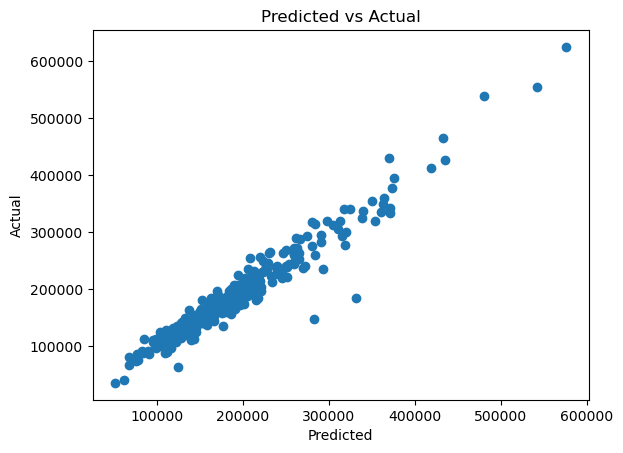

<Figure size 600x600 with 0 Axes>

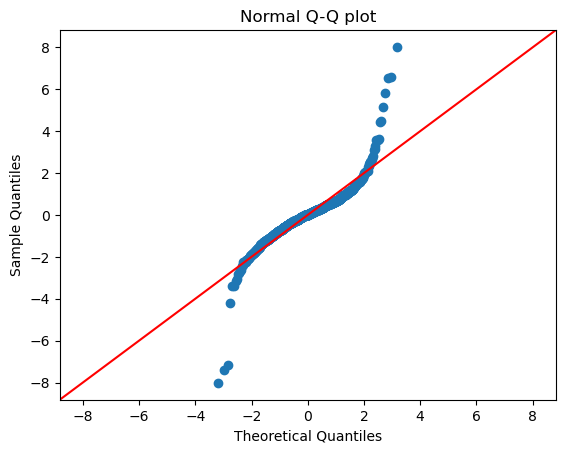

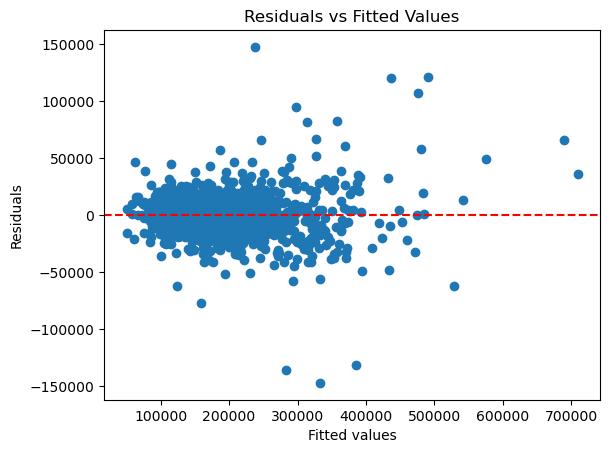

Total number of predictors in the model: 287


In [15]:
from scipy.stats import norm

# 1. Predicted vs Actual Values Plot
plt.scatter(y_test_pred, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# 2. QQ Plot
plt.figure(figsize=(6,6))
sm.qqplot(ols_model.resid, line='45', fit=True)
plt.title("Normal Q-Q plot")
plt.show()

# 3. Residuals vs Fitted Values
plt.scatter(ols_model.fittedvalues, ols_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Total number of predictors (excluding the intercept)
num_predictors = X.shape[1] - 1  # Subtract 1 to exclude the constant column

print(f'Total number of predictors in the model: {num_predictors}')

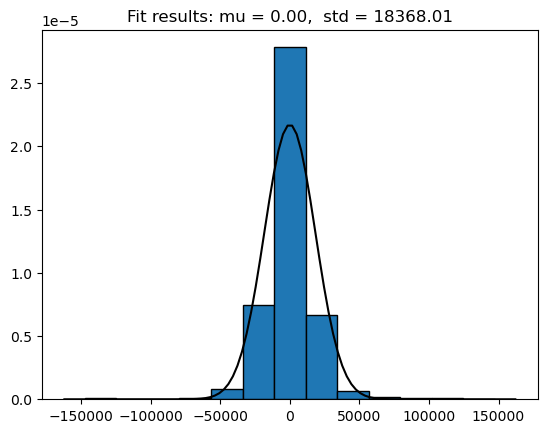

In [16]:
# 4. Density Plot of Residuals
residuals = ols_model.resid

# Fit a normal distribution to the data:
mean, std = norm.fit(residuals)

# Plot the histogram
plt.hist(residuals, bins=13, edgecolor='black', density=True)

# Generate a PDF based on the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

# Perform lasso regression on model

In [17]:
import patsy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Clean up all column names
df_encoded.columns = (
    df_encoded.columns
    .str.replace(' ', '_')              # Replace spaces with underscores
    .str.replace('[^A-Za-z0-9_]', '', regex=True)  # Remove any characters that are not alphanumeric or underscores
    .str.replace('^[0-9]', 'n', regex=True)  # Replace any column names starting with a number with 'n' followed by the original name
)

# Check the cleaned column names
print(df_encoded.columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'log_GrLivArea', 'log_1stFlrSF', 'log_TotalBsmtSF', 'log_GarageArea',
       'sqrt_LotArea', 'sqrt_GrLivArea', 'sqrt_1stFlrSF', 'sqrt_TotalBsmtSF',
       'sqrt_GarageArea', 'exp_OverallQual'],
      dtype='object', length=288)


In [18]:
# Step 1: Define the target variable and predictors
y_initial = df_encoded['SalePrice']
X_initial = df_encoded.drop(columns=['SalePrice'])

# Add a constant to the model (for intercept)
X_initial = sm.add_constant(X_initial)

# Split the data into training and testing sets
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(X_initial, y_initial, test_size=0.25, random_state=42)

# Step 2: Perform Lasso Regression with Cross-Validation to find the best alpha
lasso_cv_model_initial = LassoCV(cv=10, random_state=42)  # Using Cross-Validation to find the best alpha
lasso_cv_model_initial.fit(X_train_initial, y_train_initial)

# Get the best alpha
best_alpha_initial = lasso_cv_model_initial.alpha_
print(f'Best alpha (Initial Lasso): {best_alpha_initial}')

# Step 3: Fit the Lasso Regression with the best alpha
lasso_model_initial = Lasso(alpha=best_alpha_initial)
lasso_model_initial.fit(X_train_initial, y_train_initial)

# Step 4: Make predictions on the training and testing data
lasso_train_predictions_initial = lasso_model_initial.predict(X_train_initial)
lasso_test_predictions_initial = lasso_model_initial.predict(X_test_initial)

# Step 5: Calculate and display Train/Test MSE and MAPE for Lasso
lasso_train_mse_initial = mean_squared_error(y_train_initial, lasso_train_predictions_initial)
lasso_train_mape_initial = mean_absolute_percentage_error(y_train_initial, lasso_train_predictions_initial) * 100

lasso_test_mse_initial = mean_squared_error(y_test_initial, lasso_test_predictions_initial)
lasso_test_mape_initial = mean_absolute_percentage_error(y_test_initial, lasso_test_predictions_initial) * 100

print(f'LASSO Training MSE (Initial): {lasso_train_mse_initial}')
print(f'LASSO Training MAPE (Initial): {lasso_train_mape_initial}')
print(f'LASSO Testing MSE (Initial): {lasso_test_mse_initial}')
print(f'LASSO Testing MAPE (Initial): {lasso_test_mape_initial}')

Best alpha (Initial Lasso): 722214625.7287824
LASSO Training MSE (Initial): 2848017848.5601506
LASSO Training MAPE (Initial): 20.003391892126043
LASSO Testing MSE (Initial): 2457516485.695716
LASSO Testing MAPE (Initial): 20.073289776083406


Conclusion: Lasso regression makes model worse than initial model 

# Ridge regression on initial model 

In [19]:
from sklearn.linear_model import RidgeCV, Ridge
# Step 1: Define the target variable and predictors
y_ridge = df_encoded['SalePrice']
X_ridge = df_encoded.drop(columns=['SalePrice'])

# Add a constant to the model (for intercept)
X_ridge = sm.add_constant(X_ridge)

# Split the data into training and testing sets
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=0.25, random_state=42)

# Step 2: Perform Ridge Regression with Cross-Validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A wide range of alphas to consider
ridge_cv_model = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')  # Using Cross-Validation to find the best alpha
ridge_cv_model.fit(X_train_ridge, y_train_ridge)

# Get the best alpha
best_alpha_ridge = ridge_cv_model.alpha_
print(f'Best alpha (Ridge): {best_alpha_ridge}')

# Step 3: Fit the Ridge Regression with the best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_ridge, y_train_ridge)

# Step 4: Make predictions on the training and testing data
ridge_train_predictions = ridge_model.predict(X_train_ridge)
ridge_test_predictions = ridge_model.predict(X_test_ridge)

# Step 5: Calculate and display Train/Test MSE and MAPE for Ridge
ridge_train_mse = mean_squared_error(y_train_ridge, ridge_train_predictions)
ridge_train_mape = mean_absolute_percentage_error(y_train_ridge, ridge_train_predictions) * 100

ridge_test_mse = mean_squared_error(y_test_ridge, ridge_test_predictions)
ridge_test_mape = mean_absolute_percentage_error(y_test_ridge, ridge_test_predictions) * 100



# Get the coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train_ridge.columns)

# Filter to keep only the predictors that were retained by Ridge (i.e., non-zero coefficients)
included_predictors_ridge = ridge_coefficients[ridge_coefficients != 0].index

# Subset the training data to include only these predictors
X_train_included_ridge = X_train_ridge[included_predictors_ridge]
X_test_included_ridge = X_test_ridge[included_predictors_ridge]

# Add a constant to the model (for intercept)
X_train_included_ridge = sm.add_constant(X_train_included_ridge)
X_test_included_ridge = sm.add_constant(X_test_included_ridge)

# Refit an OLS model using only the predictors retained by Ridge
ols_model_ridge = sm.OLS(y_train_ridge, X_train_included_ridge).fit()

# Print the model summary
print("OLS Regression Model Summary with Ridge Predictors:")
print(ols_model_ridge.summary())

print(f'Ridge Training MSE: {ridge_train_mse}')
print(f'Ridge Training MAPE: {ridge_train_mape}')
print(f'Ridge Testing MSE: {ridge_test_mse}')
print(f'Ridge Testing MAPE: {ridge_test_mape}')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67841e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.44293e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57454e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24448e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.

Best alpha (Ridge): 1000000.0
OLS Regression Model Summary with Ridge Predictors:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     70.82
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:52:41   Log-Likelihood:                -11358.
No. Observations:                1027   AIC:                         2.327e+04
Df Residuals:                     752   BIC:                         2.462e+04
Df Model:                         274                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [20]:
# Get the coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train_ridge.columns)

# Count how many predictors were deleted (coefficients set to zero)
num_deleted_predictors_ridge = (ridge_coefficients == 0).sum()

# Count how many predictors were kept (coefficients not set to zero)
num_kept_predictors_ridge = (ridge_coefficients != 0).sum()

# Print the results
print(f'Number of predictors deleted by Ridge: {num_deleted_predictors_ridge}')
print(f'Number of predictors kept by Ridge: {num_kept_predictors_ridge}')

Number of predictors deleted by Ridge: 5
Number of predictors kept by Ridge: 283


# Ridge regression while dropping the data transformations 

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Step 1: Define the target variable and predictors, dropping the transformation variables
# List of transformation columns to drop
transformation_columns = [
    'log_LotArea', 'log_GrLivArea', 'log_1stFlrSF', 'log_TotalBsmtSF', 'log_GarageArea',
    'sqrt_LotArea', 'sqrt_GrLivArea', 'sqrt_1stFlrSF', 'sqrt_TotalBsmtSF', 'sqrt_GarageArea',
    'exp_OverallQual'
]

# Define the target variable and predictors
y_ridge = df_encoded['SalePrice']
X_ridge = df_encoded.drop(columns=['SalePrice'] + transformation_columns)

# Add a constant to the model (for intercept)
X_ridge = sm.add_constant(X_ridge)

# Split the data into training and testing sets
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=0.25, random_state=42)

# Step 2: Perform Ridge Regression with Cross-Validation to find the best alpha
alphas = np.logspace(-6, 6, 13)
ridge_cv_model = RidgeCV(alphas=alphas, cv=10).fit(X_train_ridge, y_train_ridge)

# Get the best alpha
best_alpha_ridge = ridge_cv_model.alpha_
print(f'Best alpha (Ridge): {best_alpha_ridge}')

# Step 3: Fit the Ridge Regression with the best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_ridge, y_train_ridge)

# Step 4: Make predictions on the training and testing data
ridge_train_predictions = ridge_model.predict(X_train_ridge)
ridge_test_predictions = ridge_model.predict(X_test_ridge)

# Step 5: Calculate and display Train/Test MSE and MAPE for Ridge
ridge_train_mse = mean_squared_error(y_train_ridge, ridge_train_predictions)
ridge_train_mape = mean_absolute_percentage_error(y_train_ridge, ridge_train_predictions) * 100

ridge_test_mse = mean_squared_error(y_test_ridge, ridge_test_predictions)
ridge_test_mape = mean_absolute_percentage_error(y_test_ridge, ridge_test_predictions) * 100

print(f'Ridge Training MSE: {ridge_train_mse}')
print(f'Ridge Training MAPE: {ridge_train_mape}')
print(f'Ridge Testing MSE: {ridge_test_mse}')
print(f'Ridge Testing MAPE: {ridge_test_mape}')

# Step 6: Count total predictors and predictors dropped by Ridge regression
coef_ridge = ridge_model.coef_

# Total predictors (excluding the intercept)
total_predictors = len(coef_ridge)

# Predictors with coefficients effectively reduced to zero
predictors_dropped = np.sum(np.isclose(coef_ridge, 0))

print(f'Total predictors used: {total_predictors}')
print(f'Total predictors dropped by Ridge regression: {predictors_dropped}')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67855e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.44305e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57463e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24452e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.

Best alpha (Ridge): 100.0
Ridge Training MSE: 461176243.6481745
Ridge Training MAPE: 8.22330032332195
Ridge Testing MSE: 1082499341.8054051
Ridge Testing MAPE: 10.122704604882529
Total predictors used: 277
Total predictors dropped by Ridge regression: 5


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.61126e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.61126e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Conclusion: Use Ridge regression after dropping the data transformation as it has the best fit between MSE and MAPE so there is not too much overfitting but enough predictability 

In [22]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import Ridge
import numpy as np
# Assuming X_train_ridge and y_train_ridge are already defined

# Define and train the Ridge model
alphas = np.logspace(-6, 6, 13)  # A wide range of alphas to consider
ridge_cv_model = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')  # Using Cross-Validation to find the best alpha
ridge_cv_model.fit(X_train_ridge, y_train_ridge)

# Get the best alpha
best_alpha_ridge = ridge_cv_model.alpha_
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_ridge, y_train_ridge)

# Get the coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train_ridge.columns)

# Filter to keep only the predictors that were retained by Ridge (i.e., non-zero coefficients)
included_predictors_ridge = ridge_coefficients[ridge_coefficients != 0].index

# Subset the training data to include only these predictors
X_train_included_ridge = X_train_ridge[included_predictors_ridge]

# Add a constant to the model (for intercept)
X_train_included_ridge = sm.add_constant(X_train_included_ridge)

# Refit an OLS model using only the predictors retained by Ridge
ols_model_ridge = sm.OLS(y_train_ridge, X_train_included_ridge).fit()

# Print the model summary
print("OLS Regression Model Summary with Ridge Predictors:")
print(ols_model_ridge.summary())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67855e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.44305e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57463e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24452e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.

OLS Regression Model Summary with Ridge Predictors:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     70.74
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:52:44   Log-Likelihood:                -11386.
No. Observations:                1027   AIC:                         2.330e+04
Df Residuals:                     763   BIC:                         2.460e+04
Df Model:                         263                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [31]:
import pandas as pd

# Load the test data
test_data = pd.read_csv(db_dir + r'/data/test.csv')
# Identify and handle missing columns
missing_columns = set(included_predictors_ridge) - set(test_data.columns)
print("Missing columns in test data:", missing_columns)

# Add missing columns with default value 0
for col in missing_columns:
    test_data[col] = 0

# Subset the test data to include only the predictors retained by Ridge
X_test_included_ridge = test_data[included_predictors_ridge]

# Add a constant to the model (for intercept)
X_test_included_ridge = sm.add_constant(X_test_included_ridge)

# Make predictions
ridge_predictions = ols_model_ridge.predict(X_test_included_ridge)

print("Ridge Predictions on Test Data:")
print(ridge_predictions)
# Prepare the submission DataFrame
submission = pd.DataFrame({
    'Id': test_data['Id'],  # Assuming 'Id' column exists in your test data
    'SalePrice': ridge_predictions
})
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

Missing columns in test data: {'RoofStyle_Mansard', 'ExterQual_TA', 'LandContour_Lvl', 'Neighborhood_NAmes', 'BsmtFinType2_Unf', 'SaleType_ConLw', 'Neighborhood_NridgHt', 'Neighborhood_CollgCr', 'Fireplaces_x_GarageCars', 'SaleType_ConLD', 'GarageQual_Po', 'HeatingQC_Fa', 'Electrical_None', 'KitchenQual_TA_x_GrLivArea', 'Neighborhood_NridgHt_x_GrLivArea', 'Neighborhood_Veenker', 'ExterCond_Gd', 'BsmtFinType1_LwQ', 'Functional_Min2', 'GarageCars_x_GarageArea', 'HeatingQC_Po', 'BsmtQual_Gd', 'LandSlope_Mod', 'SaleCondition_Alloca', 'FullBath_x_BedroomAbvGr', 'Exterior2nd_MetalSd', 'Condition2_RRAn', 'HouseStyle_SFoyer', 'MasVnrType_BrkFace', 'GarageType_Attchd', 'Condition2_RRAe', 'Neighborhood_OldTown', 'Functional_Typ', 'LotConfig_FR3', 'BsmtFinType2_BLQ', 'Neighborhood_StoneBr', 'Exterior1st_CBlock', 'Condition1_RRNe', 'RoofStyle_Shed', 'Exterior1st_Plywood', 'Exterior2nd_BrkFace', 'Neighborhood_Crawfor', 'HouseStyle_2Story', 'HouseStyle_25Fin', 'Neighborhood_Gilbert', 'GarageFinish_R

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_87536/1948707229.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[col] = 0
/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_87536/1948707229.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[col] = 0
/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_87536/1948707229.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider